## Multimodel Airline AI Assistant

In [1]:
# Importing required dependencies
import os
import json
import difflib
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr

In [2]:
load_dotenv()
openai_api_key = os.getenv('OPENAI_API_KEY')

if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")
    
MODEL = "gpt-4o-mini"
openai = OpenAI()

OpenAI API Key exists and begins sk-proj-


In [21]:
system_message = (
    "You are a knowledgeable and friendly assistant for an airline platform called SkyAssist. "
    "You help users with flight bookings, ticket prices, and flight departure information. "
    "You also provide detailed travel guides and brochures for cities around the world, including top attractions, itineraries, and visuals. "
    "Be accurate and helpful in your responses. "
    "If you don't know the answer, politely say so. "
    "Responses should be clear and courteous. Keep them brief unless a longer answer is clearly helpful, such as when explaining a travel itinerary or describing a city."
)

## Tools

Tools are an incredibly powerful feature provided by the frontier LLMs.<br>
With tools, you can write a function, and have the LLM call that function as part of its response.

In [4]:
ticket_prices = {
    "london": "$1304",
    "paris": "$1592",
    "tokyo": "$1247",
    "berlin": "$1624",
    "amsterdam": "$552",
    "new york": "$914",
    "los angeles": "$1770",
    "chicago": "$1592",
    "toronto": "$702",
    "miami": "$1075",
    "dubai": "$1244",
    "singapore": "$1325",
    "hong kong": "$1218",
    "sydney": "$1148",
    "melbourne": "$675",
    "boston": "$1114",
    "san francisco": "$1484",
    "moscow": "$1652",
    "rome": "$1694",
    "barcelona": "$1123",
    "amsterdam": "$552",
    "dubrovnik": "$986",
    "vienna": "$1114",
    "zurich": "$922"
}

flight_departures = {
    "london": ["09:21 PM", "12:55 PM"],
    "paris": ["12:22 PM"],
    "tokyo": ["06:09 AM", "10:09 PM", "01:58 PM"],
    "berlin": ["04:51 PM", "07:11 AM"],
    "amsterdam": ["06:00 AM"],
    "new york": ["07:26 PM", "11:44 PM"],
    "los angeles": ["06:57 PM", "01:09 PM", "06:25 AM"],
    "chicago": ["09:43 AM", "08:46 PM"],
    "toronto": ["04:43 PM", "08:13 AM"],
    "miami": ["06:35 PM", "02:50 AM"],
    "dubai": ["07:42 AM", "10:41 PM"],
    "singapore": ["01:55 AM", "11:23 AM"],
    "hong kong": ["08:31 AM", "05:59 PM"],
    "sydney": ["06:10 AM", "08:26 PM"],
    "melbourne": ["09:31 AM", "11:48 PM"],
    "boston": ["10:07 AM", "04:09 PM"],
    "san francisco": ["05:37 PM", "11:25 AM"],
    "moscow": ["07:49 AM", "03:33 PM"],
    "rome": ["09:33 AM", "02:22 PM"],
    "barcelona": ["07:15 AM", "01:25 PM"],
    "amsterdam": ["06:00 AM"],
    "dubrovnik": ["10:22 AM", "05:18 PM"],
    "vienna": ["09:30 AM", "12:55 PM"],
    "zurich": ["11:05 AM", "03:44 PM"]
}

airlines = {
    "london": "Nimbus Airways",
    "paris": "SkyJet",
    "tokyo": "GlobalAir",
    "berlin": "SkyJet",
    "amsterdam": "SkyJet",
    "new york": "AeroFly",
    "los angeles": "GlobalAir",
    "chicago": "AeroFly",
    "toronto": "GlobalAir",
    "miami": "Nimbus Airways",
    "dubai": "SkyJet",
    "singapore": "GlobalAir",
    "hong kong": "Nimbus Airways",
    "sydney": "AeroFly",
    "melbourne": "SkyJet",
    "boston": "Nimbus Airways",
    "san francisco": "GlobalAir",
    "moscow": "Nimbus Airways",
    "rome": "AeroFly", 
    "barcelona": "AeroFly",
    "amsterdam": "SkyJet",
    "dubrovnik": "Nimbus Airways",
    "vienna": "Nimbus Airways",
    "zurich": "GlobalAir"
}

durations = {
    "london": "14h 9m",
    "paris": "8h 40m",
    "tokyo": "4h 11m",
    "berlin": "5h 49m",
    "amsterdam": "14h 10m",
    "new york": "10h 5m",
    "los angeles": "10h 12m",
    "chicago": "5h 41m",
    "toronto": "7h 2m",
    "miami": "8h 5m",
    "dubai": "9h 25m",
    "singapore": "7h 12m",
    "hong kong": "10h 30m",
    "sydney": "11h 11m",
    "melbourne": "10h 40m",
    "boston": "9h 59m",
    "san francisco": "8h 47m",
    "moscow": "7h 38m",
    "rome": "6h 48m",
    "barcelona": "7h 58m",
    "amsterdam": "14h 10m",
    "dubrovnik": "6h 35m",
    "vienna": "7h 12m",
    "zurich": "8h 5m"
}

In [5]:
bookings = []

# Defining two tools that helps in finding and retrieving city names and ticket prices

def find_closest_city(city_name):
    city_keys = list(ticket_prices.keys())
    matches = difflib.get_close_matches(city_name, city_keys, n = 3, cutoff = 0.6)
    return matches
    
def parse_price(price_str):
    # e.g., "$1000" -> (1000, "$") 
    if price_str and price_str[0] in "$€£":
        return {"amount": int(price_str[1:]), "currency": price_str[0]}
    return {"amount": None, "currency": None}
    

In [6]:
# Tool function to get flight ticket prices

def get_ticket_price(destination_city):
    city = destination_city.lower()
    
    if city in ticket_prices:
        price_info = parse_price(ticket_prices[city])
        return {
            "city": city,
            "price": price_info,
            "airline": airlines.get(city, "Unknown"),
            "duration": durations.get(city, "Unknown")
        }
        
    else:
        suggestions = find_closest_city(city)
        return {"error": f"City '{destination_city}' not found. Did you mean: {', '.join(suggestions)}?" if suggestions else "City not found."}
        

In [7]:
get_ticket_price('Barcelona')

{'city': 'barcelona',
 'price': {'amount': 1123, 'currency': '$'},
 'airline': 'AeroFly',
 'duration': '7h 58m'}

In [8]:
get_ticket_price('Landon')

{'error': "City 'Landon' not found. Did you mean: london?"}

In [9]:
# Tool function to get flight departure times

def get_flight_departures(destination_city):
    city = destination_city.lower()
    
    if city in flight_departures:
        return {
            "city": city,
            "departures": flight_departures[city],
            "airline": airlines.get(city, "Unknown"),
            "duration": durations.get(city, "Unknown")
        }
    else:
        suggestions = find_closest_city(city)
        return {"error": f"City '{destination_city}' not found. Did you mean: {', '.join(suggestions)}?" if suggestions else "City not found."}


In [10]:
get_flight_departures('Barcelona')

{'city': 'barcelona',
 'departures': ['07:15 AM', '01:25 PM'],
 'airline': 'AeroFly',
 'duration': '7h 58m'}

In [11]:
def complete_booking(destination_city, passenger_name, departure_time):
    city = destination_city.lower()

    # Checking if the requested city name is valid
    if city not in ticket_prices:
        suggestions = find_closest_city(city)
        return {"error": f"Destination city '{destination_city}' not found. Did you mean: {', '.join(suggestions)}?" if suggestions else "Destination city not found."}

    valid_departures = flight_departures.get(city, [])
    # Checking if the departure time is valid
    if departure_time not in valid_departures:
        return {"error": f"Invalid departure time. Available times are: {', '.join(valid_departures)}"}
    
    booking_id = len(bookings) + 1
    price_info = parse_price(ticket_prices[city])

    booking_details = {
        "booking_id": booking_id,
        "destination_city": city.title(),
        "passenger_name": passenger_name,
        "departure_time": departure_time,
        "price": price_info,
        "airline": airlines.get(city, "Unknown"),
        "duration": durations.get(city, "Unknown"),
        "status": "Confirmed"
    }

    bookings.append(booking_details)
    return booking_details

In [12]:
complete_booking('Barcelona', 'Ben Gregory', '07:15 AM')

{'booking_id': 1,
 'destination_city': 'Barcelona',
 'passenger_name': 'Ben Gregory',
 'departure_time': '07:15 AM',
 'price': {'amount': 1123, 'currency': '$'},
 'airline': 'AeroFly',
 'duration': '7h 58m',
 'status': 'Confirmed'}

In [13]:
# Defining metadata for external functions or tools that the AI assistant can call during a conversation.

price_function = {
    "name": "get_ticket_price",
    "description": "Get the price, airline, and flight duration for a return ticket to the destination city. Use this when a user asks about ticket cost or flight details.",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city the customer wants to fly to (partial or full name accepted).",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}

flight_departure_function = {
    "name": "get_flight_departures",
    "description": "Fetch available flight departure times along with the airline and flight duration for a destination.",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city the user wants to fly to (partial or full name accepted).",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}

booking_function = {
    "name": "complete_booking",
    "description": "Book a flight to the destination city with a passenger name and a preferred departure time. Accepts flexible time formats like '9am', '14:00', or '2 PM'.",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The destination city for the booking (partial or full name accepted).",
            },
            "passenger_name": {
                "type": "string",
                "description": "Full name of the passenger to be booked.",
            },
            "departure_time": {
                "type": "string",
                "description": "Preferred departure time. Can be formatted loosely like '9am', '09:00', or '14:30'.",
            },
        },
        "required": ["destination_city", "passenger_name", "departure_time"],
        "additionalProperties": False
    }
}

In [15]:
tools = [
    {"type": "function", "function": price_function},
    {"type": "function", "function": flight_departure_function},
    {"type": "function", "function": booking_function}
]

In [48]:
def handle_tool_call(message):
    tool_call = message.tool_calls[0] # Gets the first tool call request
    function_name = tool_call.function.name
    arguments = json.loads(tool_call.function.arguments) # Extracts the name of the tool called and its arguments

    match function_name:
        case "get_ticket_price":
            city = arguments.get('destination_city')
            result = get_ticket_price(city)
            response_content = json.dumps({"destination_city": city, "price": result})
        case "get_flight_departures":
            city = arguments.get('destination_city')
            result = get_flight_departures(city)
            response_content = json.dumps({"destination_city": city, "departure_times": result})
        case "complete_booking":
            city = arguments.get('destination_city')
            passenger_name = arguments.get('passenger_name')
            departure_time = arguments.get('departure_time')
            result = complete_booking(city, passenger_name, departure_time)
            response_content = json.dumps(result)
        case _:
            response_content = json.dumps({"error": "Unknown tool called"}) 
            
    response = { # Prepares a response that mimics a tool reply so the model can continue the conversation with that result
        "role": "tool",
        "content": response_content,
        "tool_call_id": tool_call.id
    }
    
    return response, arguments.get('destination_city', "Unknown")

In [18]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model = MODEL, messages = messages, tools = tools)

    if response.choices[0].finish_reason == "tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        response = openai.chat.completions.create(model = MODEL, messages = messages)
    
    return response.choices[0].message.content

### Using DALL-E-3, image generation model 

In [22]:
import base64
from io import BytesIO
from PIL import Image

In [23]:
def artist(city):
    image_response = openai.images.generate(
            model = "dall-e-3",
            prompt = f"An image representing a vacation in {city}, showing tourist spots and everything unique about {city}, in a vibrant pop-art style",
            size = "1024x1024",
            n = 1,
            response_format = "b64_json",
        )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

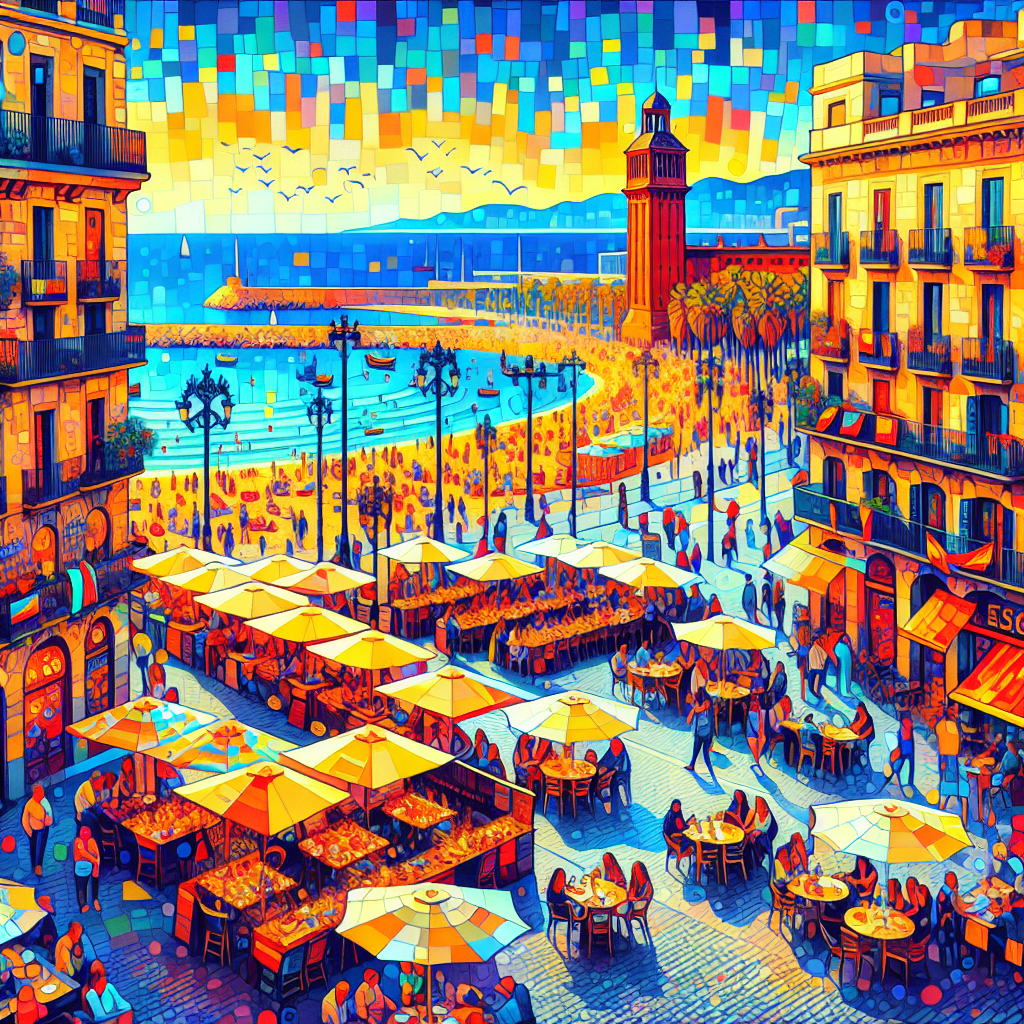

In [24]:
display(artist('Barcelona'))

### Audio generator 

In [33]:
from pydub import AudioSegment
from pydub.playback import play

def talker(message):
    response = openai.audio.speech.create(
      model = "tts-1",
      voice = "fable",    # Also, try replacing onyx with alloy
      input = message
    )
    
    audio_stream = BytesIO(response.content)
    audio = AudioSegment.from_file(audio_stream, format = "mp3")
    play(audio)

In [34]:
talker('Hi there, How are you?')

Input #0, wav, from '/var/folders/84/qnl770ks2kvg7mwlfgc5k1cw0000gn/T/tmp17j2i6jm.wav':
  Duration: 00:00:01.34, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s
   1.12 M-A:  0.000 fd=   0 aq=    0KB vq=    0KB sq=    0B 

   1.22 M-A:  0.000 fd=   0 aq=    0KB vq=    0KB sq=    0B 

In [52]:
def chat(history):
    messages = [{"role": "system", "content": system_message}] + history
    response = openai.chat.completions.create(model = MODEL, messages = messages, tools = tools)
    image = None
    
    # If a function/tool is called
    if response.choices[0].finish_reason == "tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        image = artist(city)
       
        # Continue the conversation with updated info
        response = openai.chat.completions.create(model = MODEL, messages = messages)

    reply = response.choices[0].message.content
    history.append({"role": "assistant", "content": reply})

    # Optional: Speak out the reply
    talker(reply)

    return history, image

In [53]:
with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500)
    with gr.Row():
        entry = gr.Textbox(label="Chat with SkyAssist AI Assistant:")
    with gr.Row():
        clear = gr.Button("Clear")

    def do_entry(message, history):
        history += [{"role":"user", "content":message}]
        return "", history

    entry.submit(do_entry, inputs = [entry, chatbot], outputs = [entry, chatbot]).then(
        chat, inputs = chatbot, outputs = [chatbot, image_output]
    )
    clear.click(lambda: None, inputs = None, outputs = chatbot, queue = False)

ui.launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7871
* To create a public link, set `share=True` in `launch()`.


Input #0, wav, from '/var/folders/84/qnl770ks2kvg7mwlfgc5k1cw0000gn/T/tmpoo2vtqh6.wav':
  Duration: 00:00:02.11, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s
   1.99 M-A:  0.000 fd=   0 aq=    0KB vq=    0KB sq=    0B 

Input #0, wav, from '/var/folders/84/qnl770ks2kvg7mwlfgc5k1cw0000gn/T/tmpy550db8l.wav':
  Duration: 00:00:14.62, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s
  14.57 M-A:  0.000 fd=   0 aq=    0KB vq=    0KB sq=    0B 

Input #0, wav, from '/var/folders/84/qnl770ks2kvg7mwlfgc5k1cw0000gn/T/tmpcyoq43y3.wav':
  Duration: 00:00:11.69, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s
  11.55 M-A:  0.000 fd=   0 aq=    0KB vq=    0KB sq=    0B 

Input #0, wav, from '/var/folders/84/qnl770ks2kvg7mwlfgc5k1cw0000gn/T/tmptnnk3l9y.wav':
  Duration: 00:00:24.19, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s
  24.09 M-A: -0.000 fd=   0 aq=    0KB vq=    0KB sq=    0B 